## Importing libraries

In [1]:
import os
import copy
import time
import numpy as np
import pickle

import torch
import torchvision

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

from tqdm import tqdm

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

## Implementation extracting features from images

In [2]:
def create_embedding_for_image(img_path:str, model:torch.nn.Module, preprocessing):
    """
    Creates a representation vector for the image using a pre-trained model.
    
    Parameters
    ----------
    img_path : str
        The path to the image for which the vector is being created.
    model : torch.Module
        Pre-trained model for extracting features from an image.
    preprocessing : ImageClassification
        Image preprocessing pipeline.
    """
    image = Image.open(img_path)   
    image = image.convert('RGB')
    
    preprocessed_img = preprocessing(image)[None, ...]
    
    embedding = model(preprocessed_img).flatten()
    
    return (embedding / torch.linalg.norm(embedding)).detach().numpy()

def get_file_list(root_dir:str, extensions:list=[".jpg", ".JPG", ".jpeg", ".JPEG", ".png", ".PNG"]):
    """
    Retrieves the list of names of all files.
    
    Parameters
    ----------
    root_dir : str
        The path to the directory that contains all the images.
    extensions : list(str)
        File extensions to consider.
    """
    file_list = []
    counter = 1
    
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    
    print(f"{counter} images found...")
                
    return file_list

In [3]:
weights = torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V2
preprocess = weights.transforms()

model = torchvision.models.mobilenet_v3_large(weights=weights).features
model.eval();

In [4]:
root_dir = "data/101_ObjectCategories"
filenames = sorted(get_file_list(root_dir))

9145 images found...


In [5]:
feature_list = []
for filename in tqdm(filenames):
    feature_list.append(create_embedding_for_image(filename, model, preprocess))

100%|███████████████████████████████████████████████████████████████████████████████████| 9144/9144 [03:05<00:00, 49.38it/s]


In [6]:
pickle.dump(feature_list, open("data/embedding_images.pkl", "wb"))
pickle.dump(filenames, open("data/filenames_images.pkl", "wb"))

## Definition of similarity

In [7]:
def plot_images(images:list, distances:list):
    """
    Plots the images passed in the list.
    
    Parameters
    ----------
    images : list(str)
        Paths to images.
    distances : list(float)
        Values of the distance to the first image from the list.
    """
    plt.figure(figsize=(500, 500))
    for ind, (img, dist) in enumerate(zip(images, distances)):
        plt.subplot(1, len(img), ind+1)
        plt.imshow(mpimg.imread(img))
        plt.axis("off")
        
        if dist == 0:
            plt.title(f"Target image", fontsize=25)
        else:
            plt.title(f"Distances to target images - %.2f" % dist, fontsize=25)
    
    plt.show()

In [8]:
filenames = pickle.load(open("data/filenames_images.pkl", "rb"))
embeddings = pickle.load(open("data/embedding_images.pkl", "rb"))

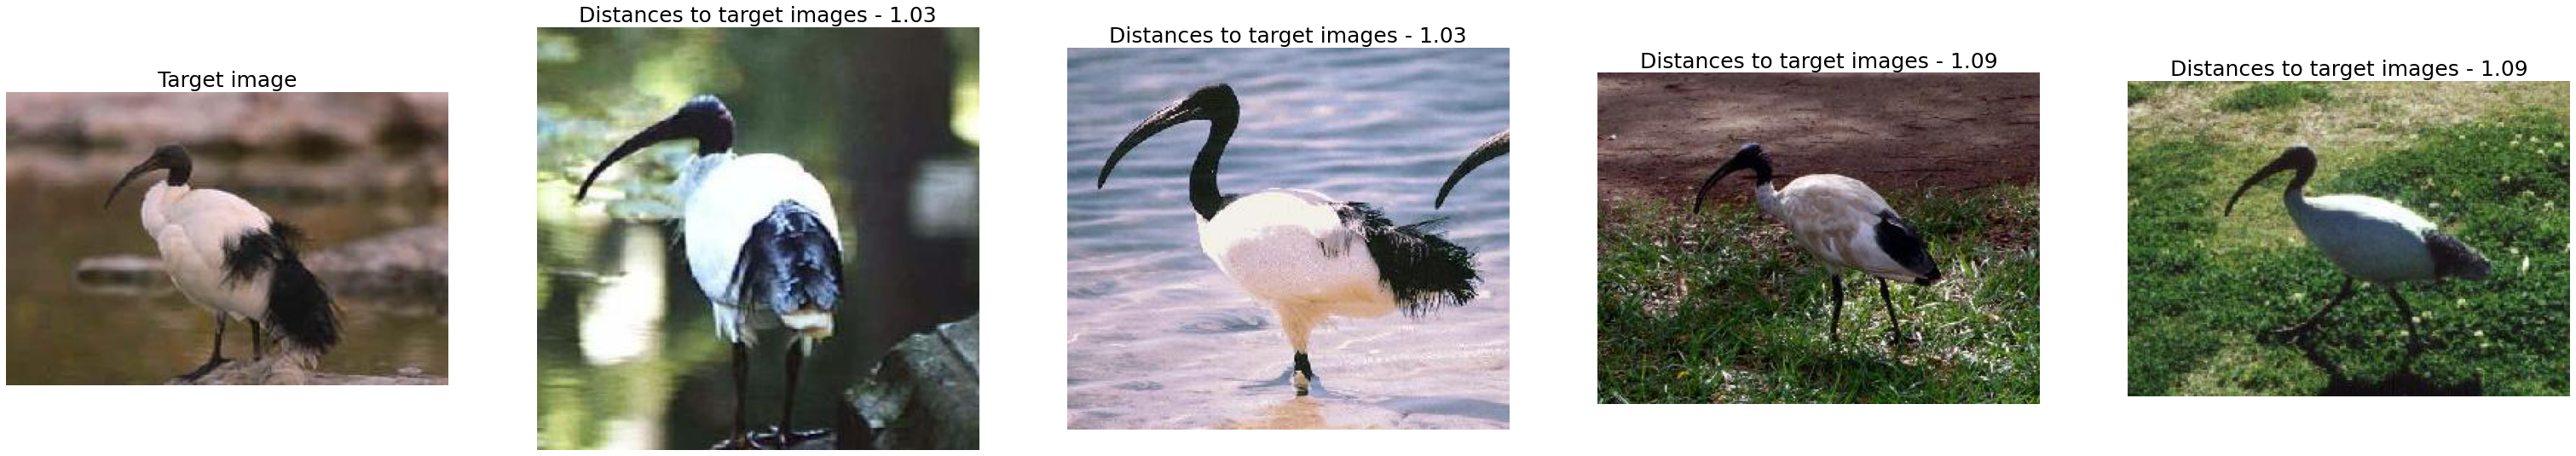

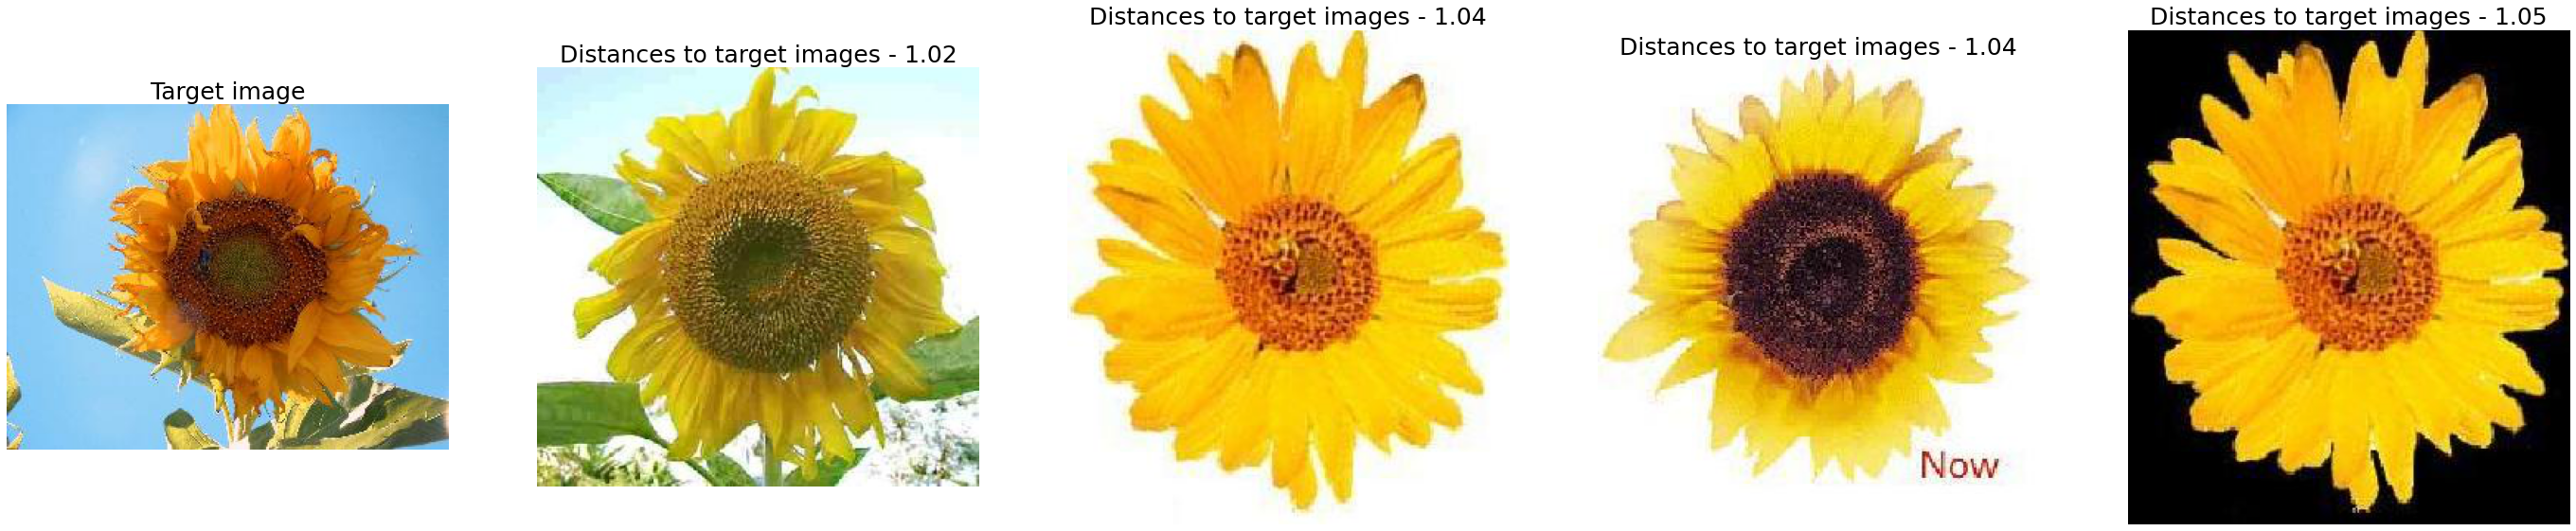

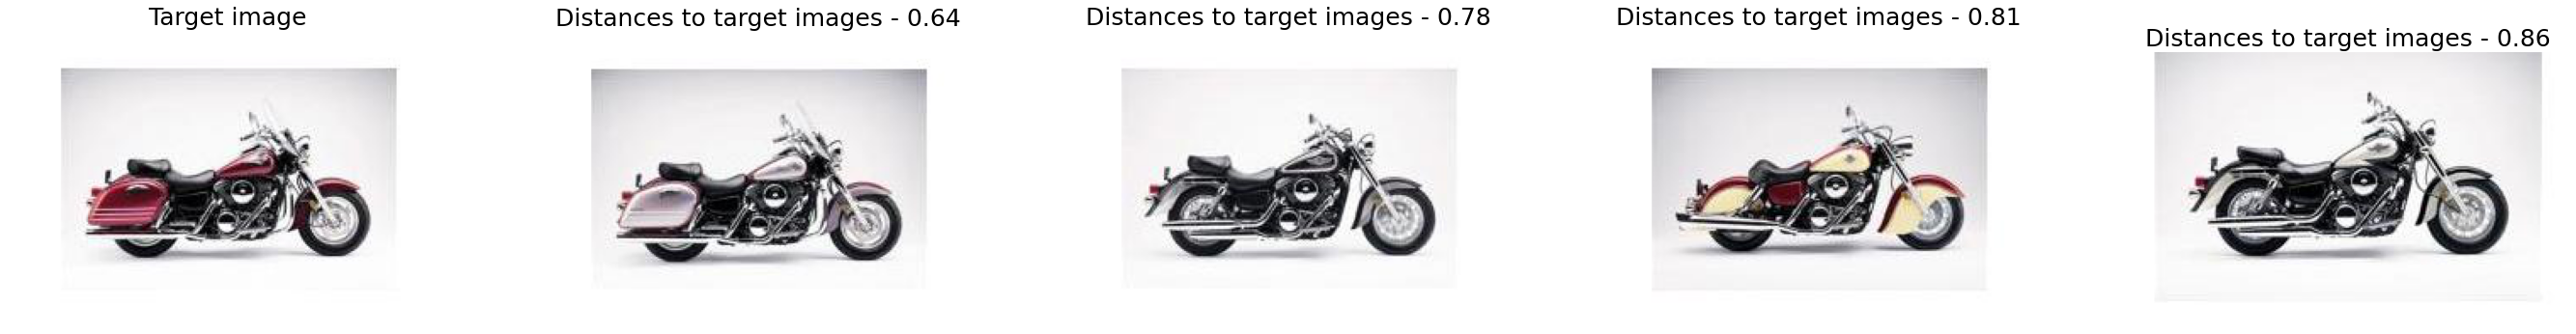

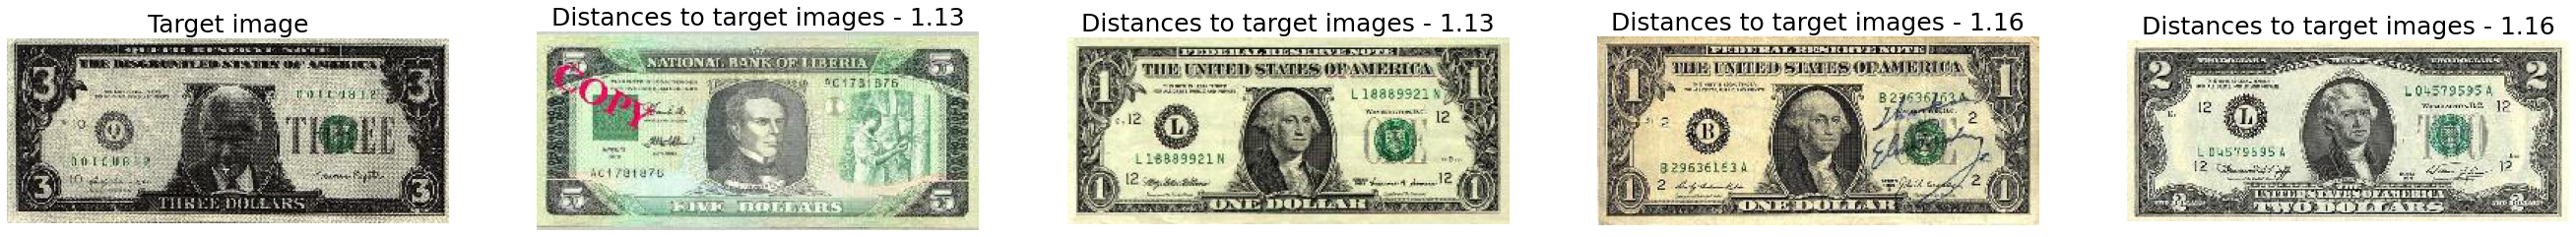

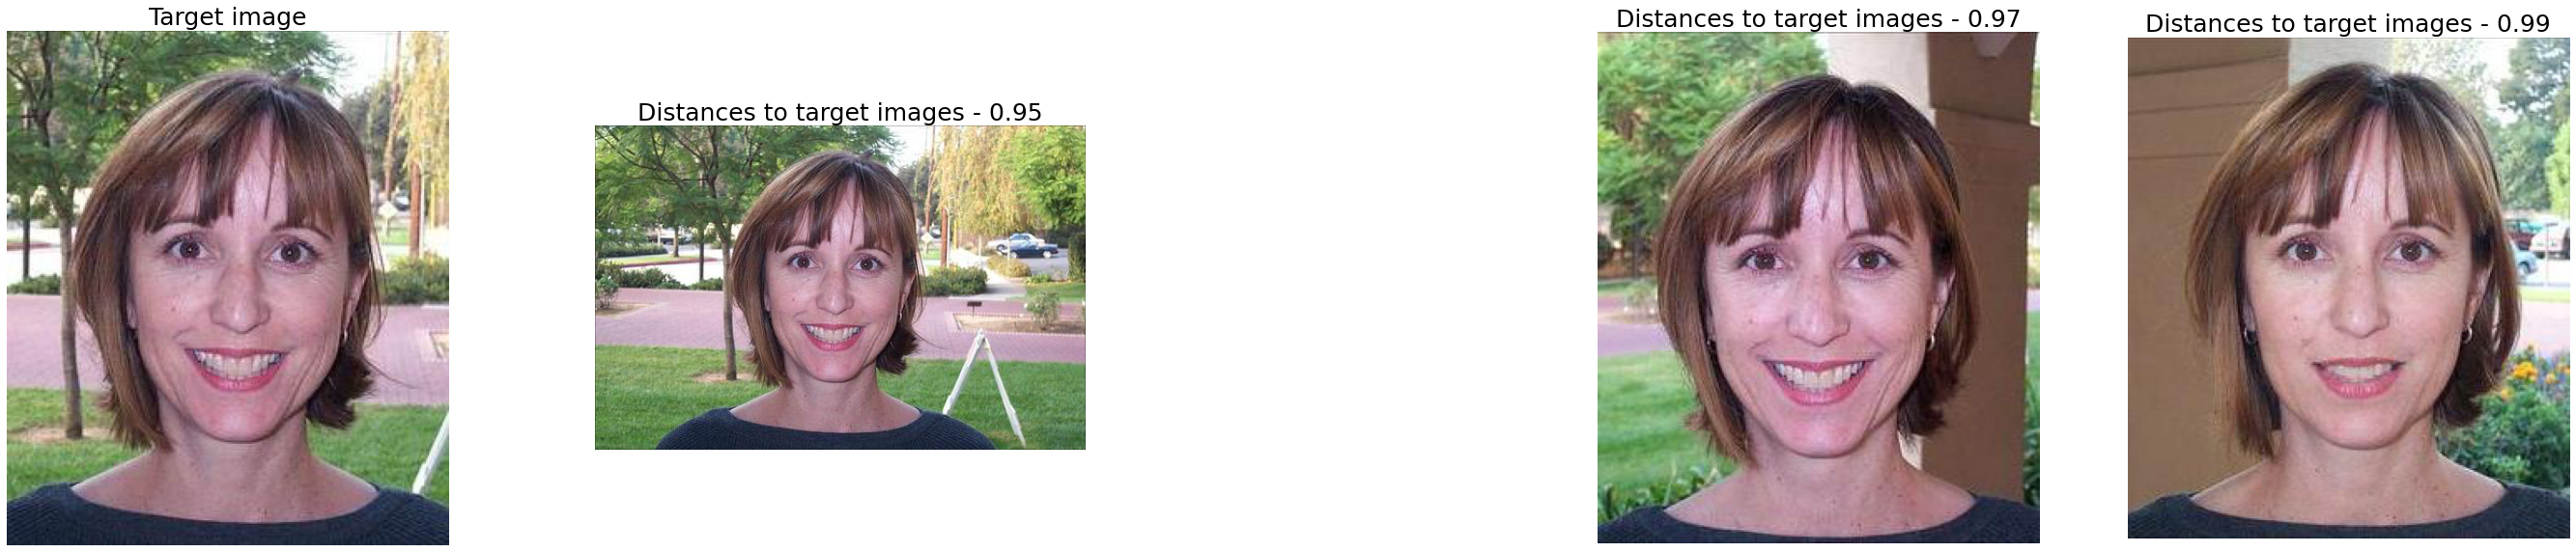

In [11]:
similarity_model = NearestNeighbors(n_neighbors=5, algorithm="brute", metric="euclidean").fit(embeddings)

num_images = len(filenames)
for i in range(5):
    random_image_index = np.random.randint(0, num_images)
    distances, indices = similarity_model.kneighbors([embeddings[random_image_index]])
    
    similarest_images = [filenames[indices[0][i]] for i in range(5)]
    plot_images(similarest_images, distances[0])

## Acceleration of work by reducing the dimension

In [13]:
def classname(filename:str):
    """
    Retrieves the class name from the path.
    """
    return filename.split('\\')[-2]

def accuracy_and_time(embeddings, filenames, num_nearest_neighbors:int=5):
    """
    Сalculates the accuracy of determining the proximity of the image and measures the operating time.
    
    Parameters
    ----------
    embeddings : list(float)
        Vector representation of images.
    filenames : list(str)
        Paths to images.
    num_nearest_neighbors : int
        The number of nearest neighbors to search for.
    """
    
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute', metric='euclidean').fit(embeddings)
    start = time.time()
    
    for emb in embeddings:
        distances, indices = neighbors.kneighbors([emb])
        
        for j in range(1, num_nearest_neighbors):
            if classname(filenames[indices[0][0]]) == classname(filenames[indices[0][j]]):
                correct_prediction += 1
            else:
                incorrect_prediction += 1
                
    end = time.time()
    
    accuracy = round(100.0 * (correct_prediction / (correct_prediction + incorrect_prediction)), 2)
    time_taken = end - start
    
    return accuracy, time_taken

### Analysis of the optimal number of features after compression

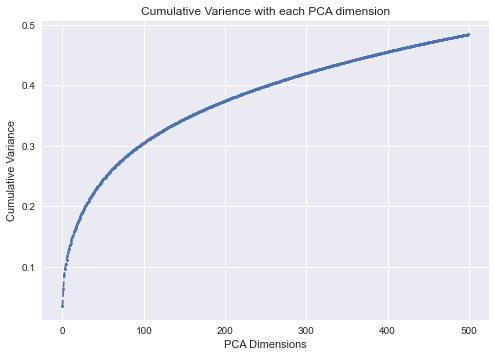

In [12]:
# Estimation of the amount of variance explained

analysis_num_features = 500

pca = PCA(analysis_num_features)
pca.fit(embeddings)

matplotlib.style.use("seaborn")

plt.plot(range(analysis_num_features), pca.explained_variance_ratio_.cumsum(), "o--", markersize=3)
plt.title("Cumulative Varience with each PCA dimension")
plt.xlabel("PCA Dimensions")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.show()

In [14]:
# Evaluation based on the ratio of accuracy and operating time

pca_dimensions = [1, 2, 5, 10, 20, 50, 100, 200, 300, 400]
pca_accuracy = []
pca_time = []

for dimensions in tqdm(pca_dimensions):
    pca = PCA(n_components=dimensions)
    pca.fit(embeddings)
    
    embeddings_compressed = pca.transform(embeddings)
    
    accuracy, time_taken = accuracy_and_time(embeddings_compressed, filenames)
    pca_time.append(time_taken)
    pca_accuracy.append(accuracy)

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:22<00:00, 38.29s/it]


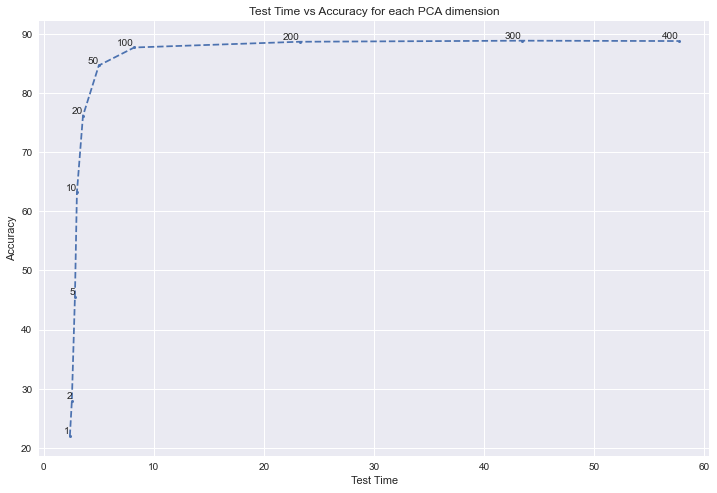

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(pca_time, pca_accuracy, "o--", markersize=3)

for label, x, y in zip(pca_dimensions, pca_time, pca_accuracy):
    plt.annotate(label, xy=(x, y), ha="right", va="bottom")

plt.title("Test Time vs Accuracy for each PCA dimension")
plt.xlabel("Test Time")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

### Saving compressed embeddings for each image

In [16]:
optimal_num_features = 100
pca = PCA(n_components=optimal_num_features).fit(embeddings)

embeddings_compressed = pca.transform(embeddings)
pickle.dump(embeddings_compressed, open("data/compressed_embeddings.pkl", "wb"))

## Prospects for improvement

To improve accuracy, **fine-tune the neural network** used. And to further increase the speed of work, use the **methods of approximate nearest neighbors** (for example, NGT, Faiss, Annoy).